## Step 1: Import libraries

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, \
    GlobalAveragePooling3D, BatchNormalization, Dropout, \
        UpSampling3D, concatenate, Flatten, ConvLSTM2D, Bidirectional, \
            Cropping3D, ZeroPadding3D, Activation, Input, UpSampling3D, \
                Conv3DTranspose
from tensorflow.keras.models import Sequential, save_model, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


%matplotlib inline

2023-03-15 15:54:18.348777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 15:54:18.497582: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 15:54:18.502896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 15:54:18.502913: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Step 2: Set Constants

In [2]:
SEED = 137
# using the range from segmentation
# [40:195,35:225,26:137]
# constants to crop images

MIN_WIDTH = 25 # 40
MAX_WIDTH = 215 # 195

MIN_HEIGHT = 35 # 35
MAX_HEIGHT = 225 # 225

MIN_DEPTH = 15 # 26
MAX_DEPTH = 143 # 137

In [3]:
#channel 
channel = 't1'

## Step 3: Load Data

In [4]:
# load data
df = pd.read_pickle(f"../../raw_data/Grade_ID_{channel}_nii.pkl")

# the target columns have to be updated, it's only the fremework
df['Grade'] = df['Grade'].apply(lambda x: 1 if x == 'HGG' else 0)

## Step 4: EDA

In [5]:
print(f"Number of samples: {df[f'{channel}_nii'].shape[0]}")
print(f"Negative examples: {df[df['Grade'] == 0].shape}")
print(f"Positive examples: {df[df['Grade'] == 1].shape}")

print("")
print("Single example Shape:")
print(f"Height: {df[f'{channel}_nii'][0].shape[0]}")
print(f"Width: {df[f'{channel}_nii'][0].shape[1]}")
print(f"Depth: {df[f'{channel}_nii'][0].shape[2]}")

Number of samples: 369
Negative examples: (76, 3)
Positive examples: (293, 3)

Single example Shape:
Height: 240
Width: 240
Depth: 155


## Step 5: Crop Images and run Augmentation

In [6]:
# crop images
df[f'{channel}_nii'] = df[f'{channel}_nii'].apply(lambda x: np.array(x[MIN_HEIGHT:MAX_HEIGHT,MIN_WIDTH:MAX_WIDTH,MIN_DEPTH:MAX_DEPTH]))
X = df[f'{channel}_nii']
y = df['Grade']

In [7]:
# reshape input data
X = np.array([np.array(val) for val in X])
if channel != 'seg':
    X[X>840]=840 # set the max value to 840
    X = (X - 0)/840 # Min-Max Scaler
#reshape the X to fit the input of Model
X = X.reshape(len(X), X[0].shape[0], X[0].shape[1], X[0].shape[2], 1)

In [8]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
# reset the index of y, so that the indexes of X and y match
y_train = y_train.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)

In [9]:
# delete the not used variables and release RAM
del [df,X]
import gc
gc.collect()

0

In [10]:
# find indices of positive examples
# pos_indices_0 = np.where(y_train == 0)[0]
# pos_indices_1 = random.sample(list(np.where(y_train == 1)[0]), 70)

# # perform data augmentation on positive examples
# rotated_examples_0_1 = np.rot90(X_train[pos_indices_0], axes=(1, 2))
# rotated_examples_0_2 = np.rot90(rotated_examples_0_1, axes=(1, 2))
# rotated_examples_0_3 = np.flip(np.concatenate([rotated_examples_0_1, rotated_examples_0_2], axis=0))
# rotated_examples_1_1 = np.rot90(X_train[pos_indices_1], axes=(1, 2))

# # append new images and labels to the training set
# X_train = np.concatenate([X_train, rotated_examples_0_1, rotated_examples_0_2,rotated_examples_0_3,
#                           rotated_examples_1_1], axis=0)
# y_train = np.concatenate([y_train, np.repeat(y_train[pos_indices_0], 4),y_train[pos_indices_1]], axis=0) 

In [11]:
X_train.shape

(295, 190, 190, 128, 1)

In [14]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([ 61, 234]))

## Step 6: Define Model

In [13]:
#define a 3D Unet modell
in_layer = Input((190, 190, 128, 1))
bn = BatchNormalization()(in_layer)
cn1 = Conv3D(8, 
             kernel_size = (1, 5, 5), 
             padding = 'same',
             activation = 'relu')(bn)
bn2 = Activation('relu')(BatchNormalization()(cn1))

dn1 = MaxPooling3D((2, 2, 2))(bn2)
cn3 = Conv3D(16, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'relu')(dn1)
bn3 = Activation('relu')(BatchNormalization()(cn3))

dn2 = MaxPooling3D((1, 2, 2))(bn3)
cn4 = Conv3D(32, 
             kernel_size = (3, 3, 3),
             padding = 'same',
             activation = 'relu')(dn2)
bn4 = Activation('relu')(BatchNormalization()(cn4))

up1 = Conv3DTranspose(16, 
                      kernel_size = (3, 3, 3),
                      strides = (1, 2, 2),
                     padding = 'same')(bn4)

cat1 = concatenate([up1, bn3], axis=2)

up2 = Conv3DTranspose(8, 
                      kernel_size = (3, 3, 3),
                      strides = (2, 2, 2),
                     padding = 'same')(cat1)

pre_out = concatenate([up2, bn2], axis=2)

#pre_out
pre_out = Conv3D(1, 
             kernel_size = (1, 1, 1), 
             padding = 'same',
             activation = 'relu')(pre_out)

#pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
#out = ZeroPadding3D((1, 2, 2))(pre_out)
#pre_out = Dense(512, activation = 'relu')(pre_out)    

pre_out = Flatten()(pre_out)

pre_out = Dense(32, activation = 'relu')(pre_out) 
out = Dense(1, activation='sigmoid')(pre_out)
sim_model = Model(inputs = [in_layer], outputs = [out])
sim_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 190, 190, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 batch_normalization (BatchNorm  (None, 190, 190, 12  4          ['input_1[0][0]']                
 alization)                     8, 1)                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 190, 190, 12  208         ['batch_normalization[0][0]']    
                                8, 8)                                                         

In [15]:
optim=Adam(learning_rate= 0.001)
sim_model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])

In [16]:
print(f" Size of X_train: {(X_train.size * X_train.itemsize) / 1e9} Gb")

 Size of X_train: 5.452544 Gb


## Step 7: Train Model

In [17]:
es = EarlyStopping(patience=5, restore_best_weights = True)
history = sim_model.fit(X_train, y_train,
                        epochs = 30,
                        batch_size = 4,
                        callbacks = [es],
                        validation_data=(X_test, y_test),
                        shuffle =True,
                        verbose = 1)
sim_model.save(f'model_glioma_{channel}_nii_3dUnet')

Epoch 1/30
74/74 [==============================] - 168s 2s/step - loss: 64.6027 - accuracy: 0.7695 - val_loss: 0.6838 - val_accuracy: 0.7973
Epoch 2/30
74/74 [==============================] - 163s 2s/step - loss: 0.7952 - accuracy: 0.7932 - val_loss: 0.6719 - val_accuracy: 0.7973
Epoch 3/30
74/74 [==============================] - 163s 2s/step - loss: 0.5648 - accuracy: 0.8034 - val_loss: 0.6642 - val_accuracy: 0.7973
Epoch 4/30
74/74 [==============================] - 163s 2s/step - loss: 0.4716 - accuracy: 0.8034 - val_loss: 0.6095 - val_accuracy: 0.7973
Epoch 5/30
74/74 [==============================] - 164s 2s/step - loss: 0.3603 - accuracy: 0.8034 - val_loss: 0.5356 - val_accuracy: 0.7973
Epoch 6/30
74/74 [==============================] - 162s 2s/step - loss: 0.2769 - accuracy: 0.8068 - val_loss: 0.5465 - val_accuracy: 0.7973
Epoch 7/30
74/74 [==============================] - 162s 2s/step - loss: 0.2638 - accuracy: 0.8169 - val_loss: 0.5384 - val_accuracy: 0.7973
Epoch 8/30
7

KeyboardInterrupt: 

In [44]:
# delete the not used variables and release RAM
del [X_train]

gc.collect()

23490

In [20]:
new_model = tf.keras.models.load_model(f'model_glioma_{channel}_nii_3dUnet')

In [45]:
#plot the learning curve
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.2)
    ax1.grid(axis="y",linewidth=0.2)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.2)
    ax2.grid(axis="y",linewidth=0.2)    

    plt.show()    

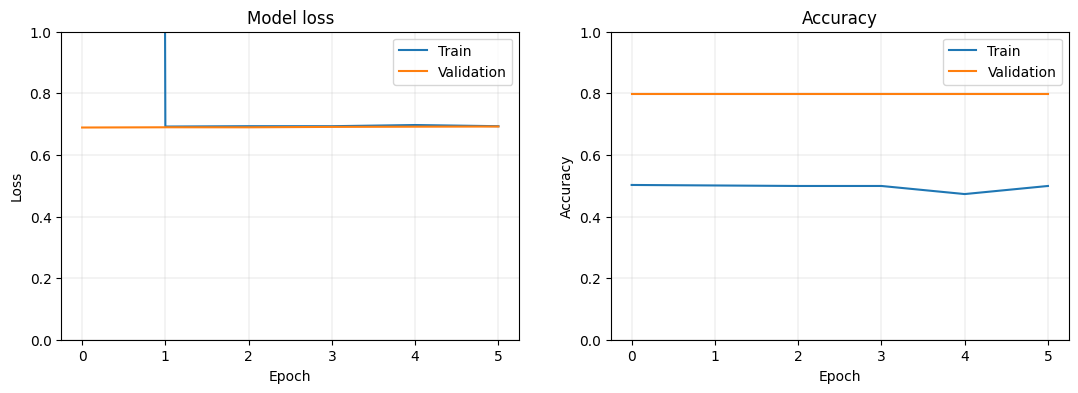

In [46]:
plot_loss(history)

In [21]:
predictions = (sim_model.predict(X_test) > 0.5).astype("int32")
predictions = pd.DataFrame(predictions)

from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions, target_names=target_names))

3/3 [==============================] - 9s 2s/step
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00        15
     class 1       0.80      1.00      0.89        59

    accuracy                           0.80        74
   macro avg       0.40      0.50      0.44        74
weighted avg       0.64      0.80      0.71        74



/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaoyx001/.pyenv/versions/3.10.6/envs/brain-tumor-project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

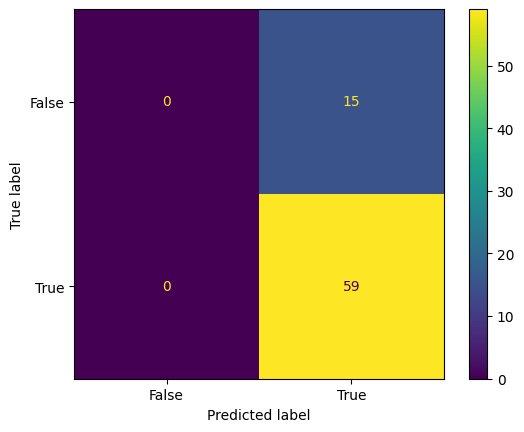

In [22]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()